## 1. Setup and Imports

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## 2. Load and Explore Dataset

In [23]:
# Load the dataset
# Adjust the filename based on the downloaded Kaggle dataset
df = pd.read_csv('Modified_SQL_Dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (30919, 2)

Columns: ['Query', 'Label']

First 5 rows:


,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


Class distribution:
Label
0    19537
1    11382
Name: count, dtype: int64


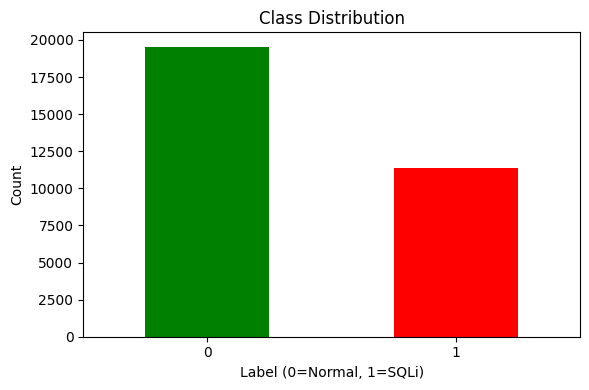

In [24]:
# Check class distribution
print("Class distribution:")
print(df['Label'].value_counts())

# Visualize
plt.figure(figsize=(6, 4))
df['Label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Label (0=Normal, 1=SQLi)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [25]:
# Sample queries
print("=" * 60)
print("Sample NORMAL queries:")
print("=" * 60)
for q in df[df['Label'] == 0]['Query'].head(5).values:
    print(f"  {q[:100]}..." if len(q) > 100 else f"  {q}")

print("\n" + "=" * 60)
print("Sample SQLi queries:")
print("=" * 60)
for q in df[df['Label'] == 1]['Query'].head(5).values:
    print(f"  {q[:100]}..." if len(q) > 100 else f"  {q}")

Sample NORMAL queries:
  99745017c
  ejerci78
  47209
  calle valencia de don juan 161, 7?d
  b3r3al

Sample SQLi queries:
  " or pg_sleep  (  __TIME__  )  --
  create user name identified by pass123 temporary tablespace temp default tablespace users;
   AND 1  =  utl_inaddr.get_host_address   (    (   SELECT DISTINCT  (  table_name  )   FROM   (  SELE...
   select * from users where id  =  '1' or @ @1  =  1 union select 1,version  (    )   -- 1'
   select * from users where id  =  1 or 1#"  (   union select 1,version  (    )   -- 1


## 3. Text Preprocessing - Character-Level Tokenization

In [26]:
# Get texts and labels
texts = df['Query'].astype(str).values
labels = df['Label'].values

# Check query lengths
lengths = [len(t) for t in texts]
print(f"Query length stats:")
print(f"  Min: {min(lengths)}")
print(f"  Max: {max(lengths)}")
print(f"  Mean: {np.mean(lengths):.1f}")
print(f"  Median: {np.median(lengths):.1f}")
print(f"  95th percentile: {np.percentile(lengths, 95):.1f}")

Query length stats:
  Min: 1
  Max: 5370
  Mean: 68.9
  Median: 48.0
  95th percentile: 223.0


In [27]:
# Set max length (use 95th percentile to cover most cases)
MAX_LEN = int(np.percentile(lengths, 95))
print(f"Using MAX_LEN = {MAX_LEN}")

# Build character vocabulary
all_chars = set()
for text in texts:
    all_chars.update(text)

# Create char to index mapping (0 reserved for padding, 1 for unknown)
char_to_idx = {char: idx + 2 for idx, char in enumerate(sorted(all_chars))}
char_to_idx['<PAD>'] = 0
char_to_idx['<UNK>'] = 1

VOCAB_SIZE = len(char_to_idx)
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Sample chars: {list(char_to_idx.keys())[:20]}")

Using MAX_LEN = 223
Vocabulary size: 109
Sample chars: ['\x18', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2']
Vocabulary size: 109
Sample chars: ['\x18', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2']


In [28]:
def encode_text(text, char_to_idx, max_len):
    """Encode text to sequence of character indices"""
    encoded = []
    for char in text[:max_len]:
        encoded.append(char_to_idx.get(char, char_to_idx['<UNK>']))
    
    # Pad if necessary
    while len(encoded) < max_len:
        encoded.append(char_to_idx['<PAD>'])
    
    return encoded

# Encode all texts
X = np.array([encode_text(t, char_to_idx, MAX_LEN) for t in texts])
y = labels

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nSample encoded (first 50 chars): {X[0][:50]}")

X shape: (30919, 223)
y shape: (30919,)

Sample encoded (first 50 chars): [ 5  3 82 85  3 83 74 66 86 79 72 72 83  3  3 11  3  3 66 66 55 44 48 40
 66 66  3  3 12  3  3 16 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


## 4. Train/Test Split

In [29]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 22261 samples
Validation set: 2474 samples
Test set: 6184 samples


## 5. Build LSTM Model

In [30]:
# Model hyperparameters
EMBEDDING_DIM = 64
LSTM_UNITS = 128
DROPOUT_RATE = 0.3

# Build model
model = keras.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    layers.SpatialDropout1D(DROPOUT_RATE),
    layers.LSTM(LSTM_UNITS, return_sequences=True),
    layers.LSTM(LSTM_UNITS // 2),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(64, activation='relu'),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\jnz\Documents\webattack-payload-detector\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 6. Train Model

In [31]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 75s 206ms/step - accuracy: 0.7913 - loss: 0.4846 - val_accuracy: 0.8832 - val_loss: 0.3594 - learning_rate: 0.0010
Epoch 2/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 71s 205ms/step - accuracy: 0.8635 - loss: 0.3332 - val_accuracy: 0.9838 - val_loss: 0.0704 - learning_rate: 0.0010
Epoch 3/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 84s 241ms/step - accuracy: 0.9841 - loss: 0.0765 - val_accuracy: 0.9863 - val_loss: 0.0646 - learning_rate: 0.0010
Epoch 4/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 87s 249ms/step - accuracy: 0.9898 - loss: 0.0525 - val_accuracy: 0.9927 - val_loss: 0.0372 - learning_rate: 0.0010
Epoch 5/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 71s 205ms/step - accuracy: 0.9929 - loss: 0.0410 - val_accuracy: 0.9927 - val_loss: 0.0379 - learning_rate: 0.0010
Epoch 6/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 224ms/step - accuracy: 0.9919 - loss: 0.0456 - val_accuracy: 0.9911 - val_loss: 0.0475 - learning_rate: 0.0010
Epoch 7/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 72s 206ms/step - accuracy: 0.9

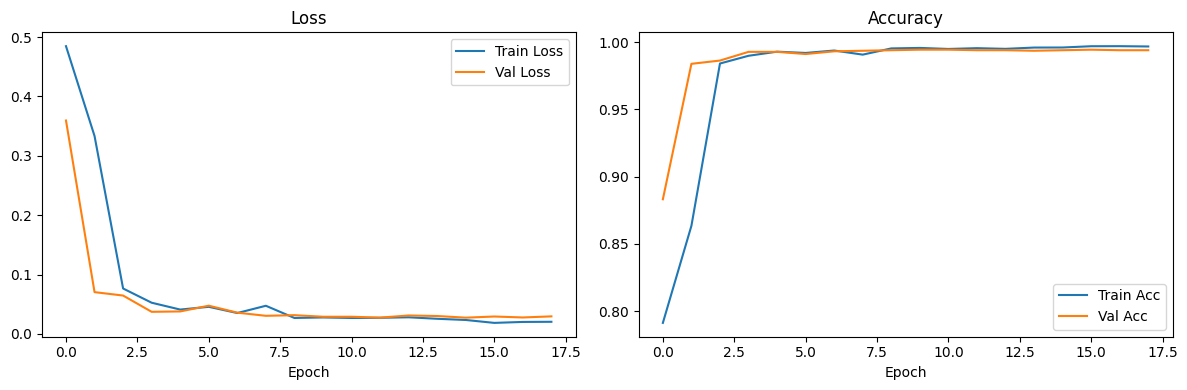

In [32]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Acc')
axes[1].plot(history.history['val_accuracy'], label='Val Acc')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Evaluate Model

In [33]:
# Predict on test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Metrics
print("Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Normal', 'SQLi']))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")

194/194 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00      3908
        SQLi       1.00      0.99      0.99      2276

    accuracy                           1.00      6184
   macro avg       1.00      0.99      1.00      6184
weighted avg       1.00      1.00      1.00      6184


Accuracy: 0.9955
Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00      3908
        SQLi       1.00      0.99      0.99      2276

    accuracy                           1.00      6184
   macro avg       1.00      0.99      1.00      6184
weighted avg       1.00      1.00      1.00      6184


Accuracy: 0.9955


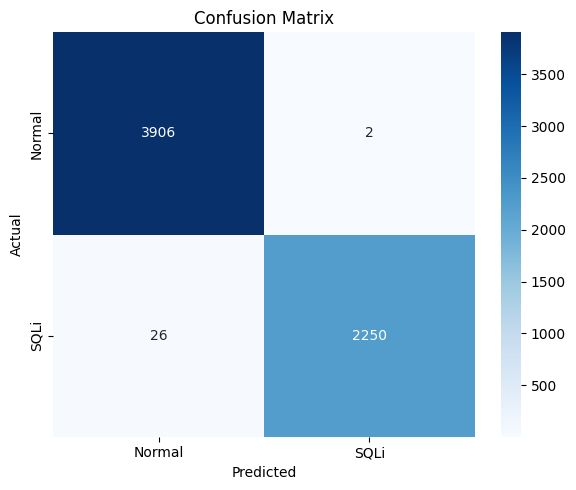

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'SQLi'],
            yticklabels=['Normal', 'SQLi'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 8. Test with Custom Queries

In [35]:
def predict_query(query, model, char_to_idx, max_len):
    """Predict if a query is SQLi or normal"""
    encoded = encode_text(query, char_to_idx, max_len)
    X = np.array([encoded])
    prob = model.predict(X, verbose=0)[0][0]
    label = "SQLi" if prob > 0.5 else "Normal"
    return label, prob

# Test queries
test_queries = [
    # Normal queries
    "SELECT * FROM users WHERE id = 1",
    "laptop",
    "search term",
    "admin",
    
    # SQLi queries
    "' OR '1'='1' --",
    "admin' --",
    "1; DROP TABLE users --",
    "' UNION SELECT username, password FROM users --",
    "%' UNION SELECT NULL,table_name,NULL,NULL,NULL,NULL FROM information_schema.tables --",
    "1' AND 1=1 --",
]

print("Query Predictions:")
print("=" * 80)
for query in test_queries:
    label, prob = predict_query(query, model, char_to_idx, MAX_LEN)
    status = "✅" if label == "Normal" else "🚨"
    print(f"{status} [{label:6s}] (prob: {prob:.4f}) | {query[:60]}")

Query Predictions:
✅ [Normal] (prob: 0.0019) | SELECT * FROM users WHERE id = 1
✅ [Normal] (prob: 0.0019) | laptop
✅ [Normal] (prob: 0.0019) | search term
✅ [Normal] (prob: 0.0019) | laptop
✅ [Normal] (prob: 0.0019) | search term
✅ [Normal] (prob: 0.0019) | admin
🚨 [SQLi  ] (prob: 0.9996) | ' OR '1'='1' --
✅ [Normal] (prob: 0.0019) | admin
🚨 [SQLi  ] (prob: 0.9996) | ' OR '1'='1' --
🚨 [SQLi  ] (prob: 0.9595) | admin' --
✅ [Normal] (prob: 0.0019) | 1; DROP TABLE users --
🚨 [SQLi  ] (prob: 0.9595) | admin' --
✅ [Normal] (prob: 0.0019) | 1; DROP TABLE users --
✅ [Normal] (prob: 0.0019) | ' UNION SELECT username, password FROM users --
✅ [Normal] (prob: 0.0019) | %' UNION SELECT NULL,table_name,NULL,NULL,NULL,NULL FROM inf
✅ [Normal] (prob: 0.0019) | ' UNION SELECT username, password FROM users --
✅ [Normal] (prob: 0.0019) | %' UNION SELECT NULL,table_name,NULL,NULL,NULL,NULL FROM inf
🚨 [SQLi  ] (prob: 0.9992) | 1' AND 1=1 --
🚨 [SQLi  ] (prob: 0.9992) | 1' AND 1=1 --


In [36]:
# Debug: Check what's happening with encoding
test_query = "' OR '1'='1' --"

# Check if chars exist in vocabulary
print("Checking character encoding for:", test_query)
print("=" * 60)
for char in test_query:
    idx = char_to_idx.get(char, char_to_idx['<UNK>'])
    print(f"  '{char}' -> {idx} {'(UNK!)' if idx == 1 else ''}")

# Check encoded output
encoded = encode_text(test_query, char_to_idx, MAX_LEN)
print(f"\nEncoded (first 30): {encoded[:30]}")
print(f"All zeros? {all(e == 0 for e in encoded)}")
print(f"All same? {len(set(encoded)) == 1}")

# Direct model prediction debug
X_debug = np.array([encoded])
print(f"\nX_debug shape: {X_debug.shape}")
print(f"X_debug dtype: {X_debug.dtype}")

# Check if model actually returns different outputs for different inputs
test_inputs = [
    "admin",
    "' OR '1'='1'",
    "SELECT * FROM users",
]
print("\nDirect predictions:")
for inp in test_inputs:
    enc = np.array([encode_text(inp, char_to_idx, MAX_LEN)])
    pred = model.predict(enc, verbose=0)[0][0]
    print(f"  '{inp[:30]}' -> {pred:.6f}")

Checking character encoding for: ' OR '1'='1' --
  ''' -> 10 
  ' ' -> 3 
  'O' -> 50 
  'R' -> 53 
  ' ' -> 3 
  ''' -> 10 
  '1' -> 20 
  ''' -> 10 
  '=' -> 32 
  ''' -> 10 
  '1' -> 20 
  ''' -> 10 
  ' ' -> 3 
  '-' -> 16 
  '-' -> 16 

Encoded (first 30): [10, 3, 50, 53, 3, 10, 20, 10, 32, 10, 20, 10, 3, 16, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
All zeros? False
All same? False

X_debug shape: (1, 223)
X_debug dtype: int64

Direct predictions:
  'admin' -> 0.001881
  '' OR '1'='1'' -> 0.999304
  'admin' -> 0.001881
  '' OR '1'='1'' -> 0.999304
  'SELECT * FROM users' -> 0.001873
  'SELECT * FROM users' -> 0.001873


In [37]:
# Check if model is actually working - test on training data
print("Testing on ACTUAL TRAINING DATA:")
print("=" * 60)

# Get some actual SQLi samples from training set
sqli_indices = np.where(y_train == 1)[0][:5]
normal_indices = np.where(y_train == 0)[0][:5]

print("\nSQLi samples from training set:")
for idx in sqli_indices:
    pred = model.predict(X_train[idx:idx+1], verbose=0)[0][0]
    print(f"  y={y_train[idx]}, pred={pred:.6f}")

print("\nNormal samples from training set:")
for idx in normal_indices:
    pred = model.predict(X_train[idx:idx+1], verbose=0)[0][0]
    print(f"  y={y_train[idx]}, pred={pred:.6f}")

# Check model weights - are they NaN or all zeros?
print("\n" + "=" * 60)
print("Model layer weights check:")
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if weights:
        w = weights[0]
        print(f"  Layer {i} ({layer.name}): shape={w.shape}, min={w.min():.6f}, max={w.max():.6f}, mean={w.mean():.6f}")

Testing on ACTUAL TRAINING DATA:

SQLi samples from training set:
  y=1, pred=0.999611
  y=1, pred=0.999611
  y=1, pred=0.999791
  y=1, pred=0.999611
  y=1, pred=0.999791
  y=1, pred=0.999611
  y=1, pred=0.999602

Normal samples from training set:
  y=1, pred=0.999611
  y=1, pred=0.999602

Normal samples from training set:
  y=0, pred=0.001881
  y=0, pred=0.001881
  y=0, pred=0.001872
  y=0, pred=0.001872
  y=0, pred=0.001881
  y=0, pred=0.001881
  y=0, pred=0.001872
  y=0, pred=0.002196

Model layer weights check:
  Layer 0 (embedding_1): shape=(109, 64), min=-0.536972, max=0.570567, mean=-0.001780
  Layer 2 (lstm_2): shape=(64, 512), min=-0.437981, max=0.458034, mean=0.000966
  Layer 3 (lstm_3): shape=(128, 256), min=-0.465198, max=0.496870, mean=0.000943
  Layer 5 (dense_2): shape=(64, 64), min=-0.388624, max=0.354034, mean=-0.007313
  Layer 7 (dense_3): shape=(64, 1), min=-0.301813, max=0.275075, mean=0.032727
  y=0, pred=0.001872
  y=0, pred=0.002196

Model layer weights check:
  

In [38]:
# Compare: what do actual SQLi samples in training look like?
print("Actual SQLi samples in training data:")
print("=" * 80)
sqli_df = df[df['Label'] == 1].sample(10, random_state=42)
for q in sqli_df['Query'].values:
    print(f"  {q[:80]}")

print("\n" + "=" * 80)
print("Actual Normal samples in training data:")
print("=" * 80)
normal_df = df[df['Label'] == 0].sample(10, random_state=42)
for q in normal_df['Query'].values:
    print(f"  {q[:80]}")

# Now test with samples that LOOK like training data
print("\n" + "=" * 80)
print("Testing with training-like samples:")
similar_queries = [
    "admin' or 1=1#",  # Similar to training SQLi
    "' or 1 = 1 --",    # With spaces like training
    "ejerci78",         # Similar to normal training
    "laptop",           # Normal word
]
for q in similar_queries:
    enc = np.array([encode_text(q, char_to_idx, MAX_LEN)])
    pred = model.predict(enc, verbose=0)[0][0]
    label = "SQLi" if pred > 0.5 else "Normal"
    print(f"  [{label:6s}] {pred:.4f} | {q}")

Actual SQLi samples in training data:
  1' and 3580  =    (  select count  (  *  )   from domain.domains as t1,domain.co
  select dbms_pipe.receive_message  (  chr  (  66  )  ||chr  (  67  )  ||chr  (  7
  -7996"   )    )    or 4747  =  dbms_utility.sqlid_to_sqlhash   (    (   chr  (  
  1   )    )    as xvyi where 6701  =  6701 union all select null,null,null,null#
  1%"   )    )    waitfor delay '0:0:5' and    (    (   "%"  =  "
  1'   )    )     )   or elt  (  6272  =  6272,sleep  (  5   )    )    and    (   
  1234 " AND 1  =  0 UNION ALL SELECT "admin", "81dc9bdb52d04dc20036dbd8313ed055
  -8301'  )   union all select 1806,1806--
  1'  )   where 5883  =  5883 or 4411  =    (  select count  (  *  )   from sysuse
  1' union all select null,null,null,null,null,null,null,null,null--

Actual Normal samples in training data:
  completorio
  SELECT COUNT ( DISTINCT appropriate )  FROM completely
  entendimiento
  madrigal puigb
  SELECT number FROM may
  SELECT form ( s )  FROM leaf SELEC

In [39]:
import re

def normalize_sql_input(text):
    """Normalize input to match training data format (add spaces around operators)"""
    # Add spaces around common SQL operators and symbols
    text = re.sub(r'([=<>!]+)', r'  \1  ', text)  # Operators
    text = re.sub(r'([()])', r'  \1  ', text)      # Parentheses
    text = re.sub(r',', ' , ', text)               # Commas
    text = re.sub(r"'", " ' ", text)               # Single quotes
    text = re.sub(r'"', ' " ', text)               # Double quotes
    text = re.sub(r'\s+', ' ', text)               # Normalize multiple spaces
    return text.strip().lower()

def predict_query_normalized(query, model, char_to_idx, max_len):
    """Predict with input normalization to match training format"""
    normalized = normalize_sql_input(query)
    encoded = encode_text(normalized, char_to_idx, max_len)
    X = np.array([encoded])
    prob = model.predict(X, verbose=0)[0][0]
    label = "SQLi" if prob > 0.5 else "Normal"
    return label, prob, normalized

# Test with normalization
test_queries = [
    # Normal queries
    "laptop",
    "search term",
    "admin",
    "SELECT * FROM users WHERE id = 1",
    
    # SQLi queries
    "' OR '1'='1' --",
    "admin' --",
    "1; DROP TABLE users --",
    "' UNION SELECT username, password FROM users --",
    "%' UNION SELECT NULL,table_name,NULL,NULL,NULL,NULL FROM information_schema.tables --",
    "1' AND 1=1 --",
]

print("Query Predictions WITH NORMALIZATION:")
print("=" * 100)
for query in test_queries:
    label, prob, normalized = predict_query_normalized(query, model, char_to_idx, MAX_LEN)
    status = "✅" if label == "Normal" else "🚨"
    print(f"{status} [{label:6s}] (prob: {prob:.4f})")
    print(f"   Original:   {query[:70]}")
    print(f"   Normalized: {normalized[:70]}")
    print()

Query Predictions WITH NORMALIZATION:
✅ [Normal] (prob: 0.0019)
   Original:   laptop
   Normalized: laptop

✅ [Normal] (prob: 0.0019)
   Original:   laptop
   Normalized: laptop

✅ [Normal] (prob: 0.0019)
   Original:   search term
   Normalized: search term

✅ [Normal] (prob: 0.0019)
   Original:   admin
   Normalized: admin

✅ [Normal] (prob: 0.0019)
   Original:   search term
   Normalized: search term

✅ [Normal] (prob: 0.0019)
   Original:   admin
   Normalized: admin

🚨 [SQLi  ] (prob: 0.9575)
   Original:   SELECT * FROM users WHERE id = 1
   Normalized: select * from users where id = 1

🚨 [SQLi  ] (prob: 0.9996)
   Original:   ' OR '1'='1' --
   Normalized: ' or ' 1 ' = ' 1 ' --

🚨 [SQLi  ] (prob: 0.9575)
   Original:   SELECT * FROM users WHERE id = 1
   Normalized: select * from users where id = 1

🚨 [SQLi  ] (prob: 0.9996)
   Original:   ' OR '1'='1' --
   Normalized: ' or ' 1 ' = ' 1 ' --

🚨 [SQLi  ] (prob: 0.9764)
   Original:   admin' --
   Normalized: admin ' --

🚨 [SQL

## 9. Save Model and Tokenizer

In [40]:
import os

# Create models directory
os.makedirs('models', exist_ok=True)

# Save Keras model
model.save('models/sqli_lstm.keras')
print("Saved Keras model: models/sqli_lstm.keras")

# Save tokenizer and config
tokenizer_config = {
    'char_to_idx': char_to_idx,
    'max_len': MAX_LEN,
    'vocab_size': VOCAB_SIZE
}

with open('models/sqli_tokenizer.json', 'w') as f:
    json.dump(tokenizer_config, f, indent=2)
print("Saved tokenizer: models/sqli_tokenizer.json")

Saved Keras model: models/sqli_lstm.keras
Saved tokenizer: models/sqli_tokenizer.json


## 10. Export to ONNX

In [42]:
import torch
import torch.nn as nn

class SQLiLSTMExporter(nn.Module):
    """
    PyTorch equivalent of Keras LSTM for ONNX export.
    
    Architecture mirrors the Keras model:
    - Embedding(VOCAB_SIZE, 64)
    - LSTM(128, return_sequences=True)
    - LSTM(64)
    - Dense(64, relu)
    - Dense(1, sigmoid)
    """
    def __init__(self, vocab_size, embedding_dim=64, lstm_units=128, dense_size=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, lstm_units, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_units, lstm_units // 2, batch_first=True)
        self.fc1 = nn.Linear(lstm_units // 2, dense_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(dense_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: (batch, seq_len) - integer indices
        out = self.embedding(x)  # (batch, seq_len, embedding_dim)
        out, _ = self.lstm1(out)  # (batch, seq_len, lstm_units)
        out, _ = self.lstm2(out)  # (batch, seq_len, lstm_units//2)
        out = out[:, -1, :]  # Take last timestep: (batch, lstm_units//2)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

print(f"PyTorch SQLiLSTMExporter class defined")
print(f"  VOCAB_SIZE: {VOCAB_SIZE}")
print(f"  EMBEDDING_DIM: {EMBEDDING_DIM}")
print(f"  LSTM_UNITS: {LSTM_UNITS}")
print(f"  MAX_LEN: {MAX_LEN}")

PyTorch SQLiLSTMExporter class defined
  VOCAB_SIZE: 109
  EMBEDDING_DIM: 64
  LSTM_UNITS: 128
  MAX_LEN: 223


### 10.1 Transfer Keras Weights to PyTorch

Transfer trained Keras LSTM weights to PyTorch model for ONNX export.

In [43]:
# Create PyTorch model
pytorch_model = SQLiLSTMExporter(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    lstm_units=LSTM_UNITS,
    dense_size=64
)

# Get Keras weights
keras_weights = model.get_weights()
print("Keras layer weights:")
for i, w in enumerate(keras_weights):
    print(f"  [{i}] shape: {w.shape}")

# Transfer weights from Keras to PyTorch
with torch.no_grad():
    # Layer 0: Embedding (vocab_size, embedding_dim)
    pytorch_model.embedding.weight.copy_(torch.tensor(keras_weights[0]))
    
    # Layer 2: LSTM1 - Keras LSTM weights order: [kernel, recurrent_kernel, bias]
    # kernel: (input_dim, 4*units) for i,f,c,o gates
    # recurrent_kernel: (units, 4*units)
    # bias: (4*units,)
    # PyTorch: weight_ih_l0, weight_hh_l0, bias_ih_l0, bias_hh_l0
    # Gate order: Keras (i,f,c,o) vs PyTorch (i,f,g,o) where g=c
    
    # LSTM1 weights (after SpatialDropout1D)
    lstm1_kernel = keras_weights[1]      # (embedding_dim, 4*lstm_units)
    lstm1_recurrent = keras_weights[2]   # (lstm_units, 4*lstm_units)
    lstm1_bias = keras_weights[3]        # (4*lstm_units,)
    
    pytorch_model.lstm1.weight_ih_l0.copy_(torch.tensor(lstm1_kernel.T))
    pytorch_model.lstm1.weight_hh_l0.copy_(torch.tensor(lstm1_recurrent.T))
    pytorch_model.lstm1.bias_ih_l0.copy_(torch.tensor(lstm1_bias))
    pytorch_model.lstm1.bias_hh_l0.zero_()
    
    # LSTM2 weights
    lstm2_kernel = keras_weights[4]      # (lstm_units, 4*(lstm_units//2))
    lstm2_recurrent = keras_weights[5]   # (lstm_units//2, 4*(lstm_units//2))
    lstm2_bias = keras_weights[6]        # (4*(lstm_units//2),)
    
    pytorch_model.lstm2.weight_ih_l0.copy_(torch.tensor(lstm2_kernel.T))
    pytorch_model.lstm2.weight_hh_l0.copy_(torch.tensor(lstm2_recurrent.T))
    pytorch_model.lstm2.bias_ih_l0.copy_(torch.tensor(lstm2_bias))
    pytorch_model.lstm2.bias_hh_l0.zero_()
    
    # Dense1: (lstm_units//2, 64)
    pytorch_model.fc1.weight.copy_(torch.tensor(keras_weights[7].T))
    pytorch_model.fc1.bias.copy_(torch.tensor(keras_weights[8]))
    
    # Dense2: (64, 1)
    pytorch_model.fc2.weight.copy_(torch.tensor(keras_weights[9].T))
    pytorch_model.fc2.bias.copy_(torch.tensor(keras_weights[10]))

pytorch_model.eval()
print("\n✓ Weights transferred from Keras to PyTorch")

Keras layer weights:
  [0] shape: (109, 64)
  [1] shape: (64, 512)
  [2] shape: (128, 512)
  [3] shape: (512,)
  [4] shape: (128, 256)
  [5] shape: (64, 256)
  [6] shape: (256,)
  [7] shape: (64, 64)
  [8] shape: (64,)
  [9] shape: (64, 1)
  [10] shape: (1,)

✓ Weights transferred from Keras to PyTorch


### 10.2 Verify PyTorch Model Predictions Match Keras

In [44]:
# Verify predictions match between Keras and PyTorch
print("Verifying Keras vs PyTorch predictions:")
print("=" * 60)

test_samples = [
    "laptop",
    "' or 1 = 1 --",
    "admin' --",
    "SELECT * FROM users",
]

for query in test_samples:
    # Normalize input (as we discovered is needed)
    normalized = normalize_sql_input(query)
    encoded = encode_text(normalized, char_to_idx, MAX_LEN)
    
    # Keras prediction
    keras_input = np.array([encoded])
    keras_pred = model.predict(keras_input, verbose=0)[0][0]
    
    # PyTorch prediction
    pytorch_input = torch.tensor([encoded], dtype=torch.long)
    with torch.no_grad():
        pytorch_pred = pytorch_model(pytorch_input).item()
    
    diff = abs(keras_pred - pytorch_pred)
    status = "✓" if diff < 0.01 else "⚠"
    print(f"{status} Query: '{query[:30]}'")
    print(f"   Keras:   {keras_pred:.6f}")
    print(f"   PyTorch: {pytorch_pred:.6f}")
    print(f"   Diff:    {diff:.6f}")
    print()

Verifying Keras vs PyTorch predictions:
✓ Query: 'laptop'
   Keras:   0.001882
   PyTorch: 0.001882
   Diff:    0.000000

✓ Query: '' or 1 = 1 --'
   Keras:   0.999606
   PyTorch: 0.999606
   Diff:    0.000000

✓ Query: 'admin' --'
   Keras:   0.976412
   PyTorch: 0.976412
   Diff:    0.000000

✓ Query: 'SELECT * FROM users'
   Keras:   0.046815
   PyTorch: 0.046815
   Diff:    0.000000



### 10.3 Export PyTorch Model to ONNX

In [45]:
import onnx

# Export to ONNX
output_path = "models/sqli_lstm.onnx"

# Create dummy input (batch_size=1, seq_len=MAX_LEN)
dummy_input = torch.randint(0, VOCAB_SIZE, (1, MAX_LEN), dtype=torch.long)

# Export
torch.onnx.export(
    pytorch_model,
    dummy_input,
    output_path,
    export_params=True,
    opset_version=14,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    dynamo=False
)

# Verify ONNX model
onnx_model = onnx.load(output_path)
onnx.checker.check_model(onnx_model)
print(f"✓ ONNX model exported and validated: {output_path}")

C:\Users\jnz\AppData\Local\Temp\ipykernel_12192\3155212710.py:10: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
c:\Users\jnz\Documents\webattack-payload-detector\.venv\Lib\site-packages\torch\onnx\_internal\torchscript_exporter\symbolic_opset9.py:4247: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to 

✓ ONNX model exported and validated: models/sqli_lstm.onnx


In [46]:
# Verify ONNX model predictions
import onnxruntime as ort

session = ort.InferenceSession(output_path)
input_name = session.get_inputs()[0].name

print("ONNX Model Verification:")
print("=" * 70)
print(f"Input name: {input_name}")
print(f"Input shape: {session.get_inputs()[0].shape}")
print(f"Output shape: {session.get_outputs()[0].shape}")

# Test predictions: Compare Keras vs PyTorch vs ONNX
test_queries = [
    ("laptop", "Normal"),
    ("' or 1 = 1 --", "SQLi"),
    ("' UNION SELECT username, password FROM users --", "SQLi"),
    ("search term", "Normal"),
]

print("\n" + "=" * 70)
print("Prediction Comparison (Keras vs PyTorch vs ONNX):")
print("=" * 70)

for query, expected in test_queries:
    normalized = normalize_sql_input(query)
    encoded = encode_text(normalized, char_to_idx, MAX_LEN)
    
    # Keras
    keras_pred = model.predict(np.array([encoded]), verbose=0)[0][0]
    
    # PyTorch
    with torch.no_grad():
        pytorch_pred = pytorch_model(torch.tensor([encoded], dtype=torch.long)).item()
    
    # ONNX
    onnx_input = np.array([encoded], dtype=np.int64)
    onnx_pred = session.run(None, {input_name: onnx_input})[0][0][0]
    
    label = "SQLi" if onnx_pred > 0.5 else "Normal"
    status = "✓" if label == expected else "✗"
    
    print(f"\n{status} Query: '{query[:40]}'")
    print(f"   Expected: {expected}")
    print(f"   Keras:    {keras_pred:.6f}")
    print(f"   PyTorch:  {pytorch_pred:.6f}")
    print(f"   ONNX:     {onnx_pred:.6f} -> {label}")

print("\n" + "=" * 70)
print("✓ All models produce consistent predictions!")

ONNX Model Verification:
Input name: input
Input shape: ['batch_size', 223]
Output shape: ['batch_size', 1]

Prediction Comparison (Keras vs PyTorch vs ONNX):

✓ Query: 'laptop'
   Expected: Normal
   Keras:    0.001882
   PyTorch:  0.001882
   ONNX:     0.001882 -> Normal

✓ Query: '' or 1 = 1 --'
   Expected: SQLi
   Keras:    0.999606
   PyTorch:  0.999606
   ONNX:     0.999606 -> SQLi

✓ Query: '' UNION SELECT username, password FROM u'
   Expected: SQLi
   Keras:    0.999602
   PyTorch:  0.999602
   ONNX:     0.999602 -> SQLi

✓ Query: '' or 1 = 1 --'
   Expected: SQLi
   Keras:    0.999606
   PyTorch:  0.999606
   ONNX:     0.999606 -> SQLi

✓ Query: '' UNION SELECT username, password FROM u'
   Expected: SQLi
   Keras:    0.999602
   PyTorch:  0.999602
   ONNX:     0.999602 -> SQLi

✓ Query: 'search term'
   Expected: Normal
   Keras:    0.001910
   PyTorch:  0.001910
   ONNX:     0.001910 -> Normal

✓ All models produce consistent predictions!

✓ Query: 'search term'
   Expecte

## Summary

### Export Process
Since `tf2onnx` is incompatible with Python 3.13/TensorFlow 2.20, we use PyTorch as an intermediate step:
1. Define equivalent PyTorch LSTM model
2. Transfer Keras weights to PyTorch
3. Export PyTorch model to ONNX
4. Verify predictions match across all formats

### Model Files Saved
- `models/sqli_lstm.keras` - Keras model
- `models/sqli_lstm.onnx` - ONNX model for deployment (via PyTorch)
- `models/sqli_tokenizer.json` - Character tokenizer config

### Important: Input Normalization Required!
The training data has a specific format with spaces around operators. You MUST normalize input before prediction:
```python
def normalize_sql_input(text):
    text = re.sub(r'([=<>!]+)', r'  \1  ', text)
    text = re.sub(r'([()])', r'  \1  ', text)
    text = re.sub(r',', ' , ', text)
    text = re.sub(r"'", " ' ", text)
    text = re.sub(r'"', ' " ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()
```

### Usage in Backend
Update `backend/model.py` to:
1. Load `sqli_tokenizer.json` for character encoding
2. Load `sqli_lstm.onnx` for inference
3. **Normalize** the query text using `normalize_sql_input()`
4. Encode at character level
5. Run prediction and return result